# **package_LAB**

In [1]:
import numpy as np
import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)

from package_LAB import LL_RT, PID_RT, IMCTuning, Margins, Controller, install_and_import, ExperimentControl
from package_DBR import SelectPath_RT, Delay_RT, Process


In [2]:
#plotly imports

# DO NOT SKIP THIS STEP !!!!!

install_and_import('plotly')
install_and_import('ipywidgets')
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interactive, VBox

## LL_RT()

In [3]:
help(LL_RT)

Help on function LL_RT in module package_LAB:

LL_RT(MV, Kp, TLead, TLag, Ts, PV, PVInit=0, method='EBD')
    The function "FO_RT" needs to be included in a "for or while loop".
    
    :MV: input vector
    :Kp: process gain
    :TLead: Lead time constant [s]
    :TLag: Lag time constant [s]
    :Ts: sampling period [s]
    :PV: output vector
    :PVInit: (optional: default value is 0)
    :method: discretization method (optional: default value is 'EBD')
        EBD: Euler Backward di fference
        EFD: Euler Forward difference
        TRAP: Trapezoidal method
    
    The function "FO_RT" appends a value to the output vector "PV".
    The appended value is obtained from a recurrent equation that depends on the discretization method.



In [4]:
# Define simulation parameters
TSim = 100
Ts = 0.5
N = int(TSim / Ts) + 1
theta = 5

# Define MV path
MVPath = {0: 0, 5: 1, 50: 2, 80: 3, TSim: 3}

# Initialize lists
t = []
MV = []
MVDelay = []
PV_EBD_1 = []
PV_EFD_1 = []

# Generate time vector and simulate MV and MV_Delay
for i in range(0, N):
    t.append(i * Ts)
    SelectPath_RT(MVPath, t, MV)
    Delay_RT(MV, theta, Ts, MVDelay)

# Create figure
f = go.FigureWidget(make_subplots(rows=2, cols=1, specs = [[{}], [{}]], vertical_spacing = 0.1, row_heights=[0.5, 0.5]))

f.add_trace(go.Scatter(x=t, y=MVDelay, name="MV Delayed"), row=1, col=1)
f.add_trace(go.Scatter(x=t, y=MV, name="MV"), row=1, col=1)
f.add_trace(go.Scatter(x=t, name="PV with EBD"), row=2, col=1)
f.add_trace(go.Scatter(x=t, name="PV with EFD"), row=2, col=1)
    
def update_TLead(TLead, TLag, Kp):
    # Reset list
    PV_EBD_1 = []
    PV_EFD_1 = []
    
    # Generate time vector and simulate MV, MV_Delay, and PV_EBD_1
    for i in range(0, N):
        LL_RT(MVDelay[0:i+1], Kp, TLead, TLag, Ts, PV_EBD_1)
        LL_RT(MVDelay[0:i+1], Kp, TLead, TLag, Ts, PV_EFD_1, method='EFD')

    #f.data[2].x = t
    f.data[2].y = PV_EBD_1
    #f.data[3].x = t
    f.data[3].y = PV_EFD_1
    
# Update layout
f['layout'].update(height=800, width=1000)
f['layout']['xaxis1'].update(title='Time (s)')
f['layout']['yaxis1'].update(title='MV [°C]')
f['layout']['xaxis2'].update(title='Time (s)')
f['layout']['yaxis2'].update(title='PV [°C]')

# Create interactive widget
TLead_slider = interactive(update_TLead, TLead=(0, 50, 1), TLag=(0, 50, 1), Kp=(0, 10, 0.1))

# Display figure and widget
vb = VBox([f, TLead_slider])
vb.layout.align_items = 'center'
vb

    'data': [{'name': 'MV Delayed',
              'type': 'scatter',
           …

## PID_RT

In [5]:
help(PID_RT)

Help on function PID_RT in module package_LAB:

PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF=False, PVInit=0, methodI='EBD', methodD='EBD')
    The function "PID_RT" needs to be included in a "for or while loop".
    
    :SP: SetPoint vector
    :PV: Process Value vector
    :Man: Manual controller mode vector [bool]
    :MVMan: Manual value for MV vector
    :MVFF: FeedForward vector
    
    :Kc: Controller gain [float]
    :Ti: Integral time constant [s]
    :Td: Derivative time constant [s]
    :alpha: Proportionality factor for Tfd = alpha*Td where Tfd is the derivative filter time constant [s]
    :Ts: Sampling period [s]
    
    :MVMin: Minimum value for MV (for saturation of MV) [float]
    :MVMax: Maximum value for MV (for saturation of MV) [float]
    
    :MV: Manipulated Value vector
    :MVP: Proportional part of MV vector
    :MVI: Integral part of MV vector
    :MVD: Derivative part of MV vector
    :E: Control Error

In [6]:
# Define simulation parameters
TSim = 300
Ts = 0.5
N = int(TSim / Ts) + 1

# Initialize lists
t = []
SP = []
PV = []
Man = []
MVMan = []
MVFF = []
MV = []
MVp = []
MVi = []
MVd = []
E = []


# Set maximum and minimum MV values
MVmin = 0
MVmax = 100

# Define paths for manual mode
ManPath = {0: False, 130: True, 170: False} 
MVManPath = {0: 30}

# Define paths for SP and PV
SPPath = {0: 50, 5: 60} 
PVpath = {0: 50}   

MVFFPath = {0: 0, 270: 10, TSim: 10}

for i in range(0, N):
    t.append(i * Ts)
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(PVpath, t, PV)
    SelectPath_RT(ManPath, t, Man)
    SelectPath_RT(MVManPath, t, MVMan)
    SelectPath_RT(MVFFPath, t, MVFF)

In [7]:
# Add PV_EBD_1 traces for different TD, Kc and alpha values
def update_PID(Kc, TD, alpha):
        
    # Reset list
    MV = []
    MVp = []
    MVi = []
    MVd = []
    E = []

    TI = TD/0.25
    
    # Generate time vector and simulate MV, MVp, MVi, MVd, and E
    for i in range(0, N):
        PID_RT(SP[0:i+1], PV[0:i+1], Man[0:i+1], MVMan[0:i+1], MVFF[0:i+1], Kc, TI, TD, alpha, Ts, MVmin, MVmax, MV, MVp, MVi, MVd, E, ManFF=True)
    
    # Update traces
    fig.data[0].y = E
    fig.data[1].y = MVFF
    fig.data[2].y = Man
    fig.data[3].y = MV
    fig.data[4].y = MVp
    fig.data[5].y = MVi
    fig.data[6].y = MVd


# Create figure
fig = go.FigureWidget(make_subplots(rows=4, cols=1, specs = [[{}], [{}], [{}], [{}]], vertical_spacing = 0.15, row_heights=[0.2, 0.5, 0.1, 0.2], subplot_titles=("Error", "MV components", "Manual Mode", "FeedForward")))
fig.add_trace(go.Scatter(x=t, y=E, name="E"), row=1, col=1)
fig.add_trace(go.Scatter(x=t, y=MVFF, name="MVFF"), row=4, col=1)
fig.add_trace(go.Scatter(x=t, y=Man, name="Man"), row=3, col=1)
fig.add_trace(go.Scatter(x=t, y=MV, name="MV"), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=MVp, name="MVp", line=dict(dash='dash')), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=MVi, name="MVi", line=dict(dash='dash')), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=MVd, name="MVd", line=dict(dash='dash')), row=2, col=1)


# Update layout
fig['layout'].update(height=800, width=800)
fig['layout']['xaxis1'].update(title='Time (s)')
fig['layout']['xaxis2'].update(title='Time (s)')

# Create interactive widget
TLead_slider = interactive(update_PID, Kc=(0, 5, 0.1), TD=(1, 51, 1), alpha=(0.2, 0.9, 0.1))

# Display figure and widget
vb = VBox([fig, TLead_slider])
vb.layout.align_items = 'center'
vb

    'data': [{'name': 'E',
              'type': 'scatter',
              'uid':…

## IMCTuning()

In [8]:
help(IMCTuning)

Help on function IMCTuning in module package_LAB:

IMCTuning(K, T1p, T2p=0.0, theta=0.0, gamma=0.5, model='SOPDT')
    "IMCTuning" returns the tuning parameters for a PID controller based on the Internal Model Control (IMC) method.
    
    :K: Process gain
    :T1p: First process time constant [s]
    :T2p: Second process time constant [s]
    :theta: Delay [s]
    :gamma: Factor between closed-loop time constant and open-loop time constant `T_CLP = gamma * T_OLP`
    :model: Process model (optional: default is 'SOPDT')
        FOPDT: First Order Plus Dead Time
        SOPDT: Second Order Plus Dead Time
    
    :returns: tuple with Kc, Ti, Td



In [9]:
# Optimal parameters for MV SOPDT model
Kp = 0.30788564834253684
T1 = 183.81942938046797
T2 = 3.2920224028341535e-12
theta = 20.015407110302775

Kc, Ti, Td = IMCTuning(Kp, T1, T2, theta, 0.5)
print(f"Kc: {Kc:.3f}, Ti: {Ti:.3f}, Td: {Td:.3f}")

Kc: 5.334, Ti: 183.819, Td: 0.000


## Margins()

In [10]:
help(Margins)

Help on function Margins in module package_LAB:

Margins(P: package_DBR.Process, C: package_LAB.Controller, omega, show=True)
    "Margins" plot the Bode diagram of the loop `L(s) = P(s)*C(s)` and calculate gain & phase margins.
    
    :P: Process as defined by the class "Process".
        Use the following command to define the default process which is simply a unit gain process:
            `P = Process({})`
        
        Use the following commands for a SOPDT process:
            `P = Process({'Kp' : 1.1, 'theta' : 2.0, 'Tlag1' : 10.0, 'Tlag2' : 2.0})`
            
        Use the following commands for a unit gain Lead-lag process:
            `P = Process({'Tlag1' : 10.0, 'Tlead1' : 15.0})`
            
    :C: Controller as defined by the class "Controller".
        Use the following command to define the default controller which is simply a unit gain controller:
            `C = Controller({})`
        
        Use the following commands for a PID controller:
            `C

Gain margin GM = 18.87234 dB at 0.08 rad/s
Phase margin PM = 79.76042° at 0.01 rad/s


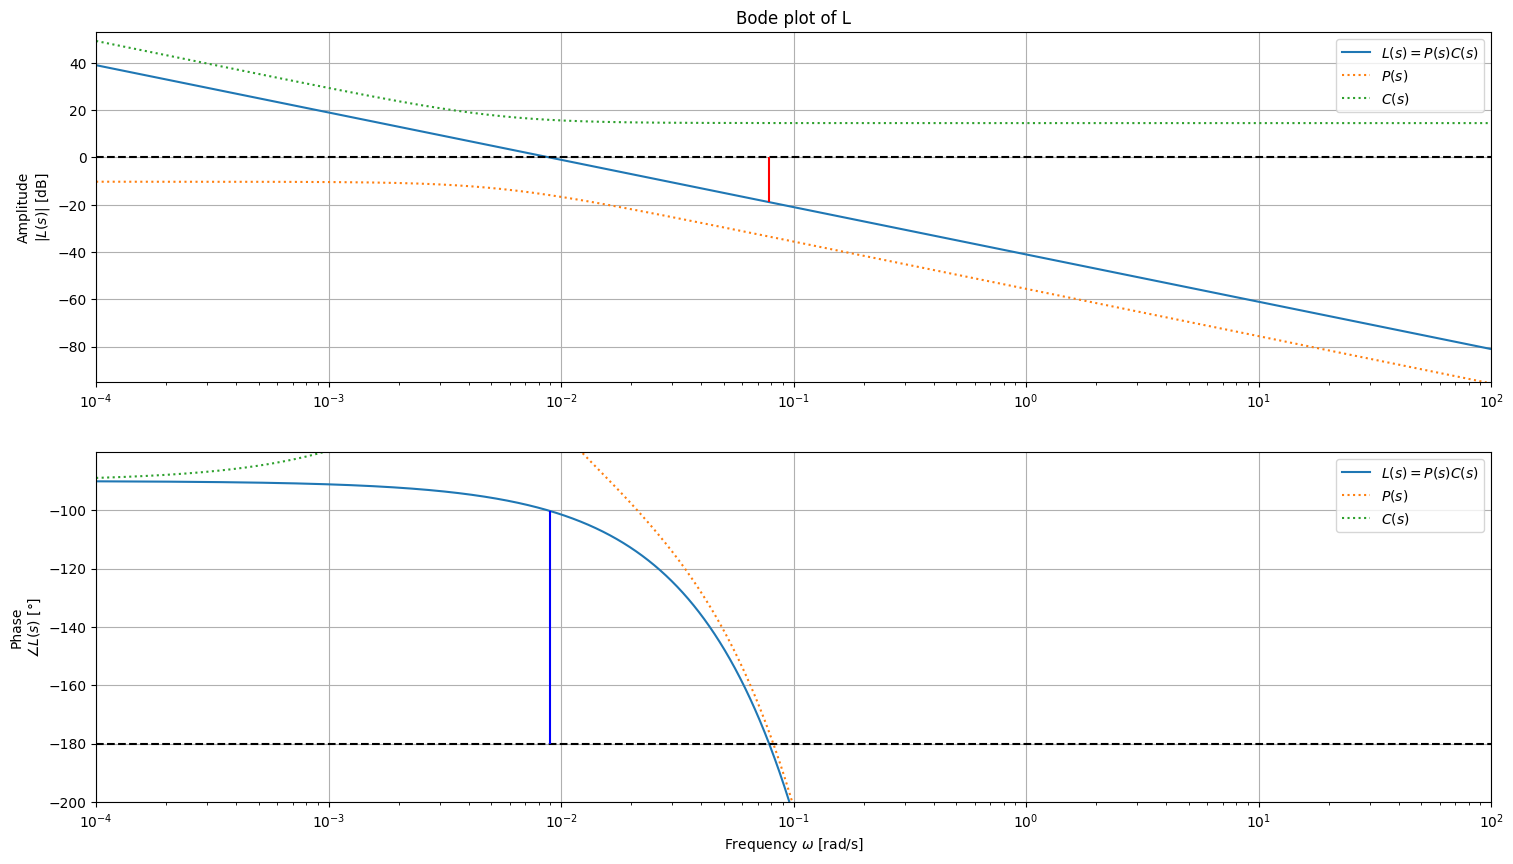

In [11]:
# SOPDT Process with optimal parameters
P = Process({'Kp' : Kp, 'Tlag1' : T1, 'Tlag2' : T2, 'theta' : theta})

# PID Controller from SOPDT IMC tuning with optimal parameters
alpha = 1
C = Controller({'Kc' : Kc, 'Ti' : Ti, 'Td' : Td, 'Tfd' : alpha*Td})

omega = np.logspace(-4, 2, 10000)

Margins(P, C, omega)

## install_and_import()

In [12]:
help(install_and_import)

Help on function install_and_import in module package_LAB:

install_and_import(package)
    Tries to import a package, if it fails, it installs the package using pip and tries to import it again.
    
    Parameters
    ----------
    package : str
        The name of the package to import.



## ExperimentControl class 

In [13]:
help(ExperimentControl)

Help on class ExperimentControl in module package_LAB:

class ExperimentControl(builtins.object)
 |  ExperimentControl(alpha, gamma, PVParam, DVParam, DV0, MV0, PV0, MVMin, MVMax, TSim, Ts)
 |  
 |  This class creates a GUI for the real-time simulation or hardware operation of a process with a PID controller.
 |  It allows adjusting several parameters such as the setpoint, manual mode, perturbation, feedforward, controller parameters, and the simulation time step.
 |  
 |  Usage:
 |      - Create an instance of the class with the required parameters.
 |      - Call `createPlot` to generate the plot.
 |      - Interact with the simulation through the GUI.
 |  
 |  Parameters:
 |      alpha (float): Proportionality factor for Tfd = alpha * Td, where Tfd is the derivative filter time constant [s].
 |      gamma (float): Ratio between closed-loop and open-loop time constants `T_CLP = gamma * T_OLP`.
 |      PVParam (list): Process parameters [Kp, T1, T2, theta].
 |      DVParam (list): Dis

In [14]:
E = ExperimentControl(
	alpha=0.7,
	gamma=0.5,
	PVParam=[0.308, 183.8, 3.29e-12, 20.02],
	DVParam=[0.295, 182.26, 13.18, 29],
	DV0=50,
	MV0=50,
	PV0=49.3,
	MVMax=100,
	MVMin=0,
	TSim=3000,
	Ts=1,
)

E.createPlot()

    'data': [{'name': 'SP',
              'type': 'scatter',
              'uid'…